In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Charger le fichier Excel
file_path = 'Crédit.xlsx'
df = pd.read_excel(file_path)

In [3]:
# Afficher les premières lignes du dataset
print(df.head())

# Afficher des informations sur le dataset
print(df.info())

# Afficher des statistiques descriptives
print(df.describe())

# Afficher les noms des colonnes
print(df.columns)

   KIDEN     Type de client       Age du client Situation familiale  \
0      5         bon client  plus de     50 ans         célibataire   
1     11         bon client  moins de    23 ans         célibataire   
2     18  mauvais    client  de 23 à     40 ans                veuf   
3     24         bon client  de 23 à     40 ans             divorcé   
4     30         bon client  moins de    23 ans         célibataire   

            Ancienneté Domiciliation du salaire Domiciliation de l'épargne  \
0   anc. plus   12 ans        domicile  salaire              pas d'épargne   
1  anc. 1 an  ou moins        domicile  salaire              pas d'épargne   
2  anc. de 6  à 12 ans        domicile  salaire              pas d'épargne   
3   anc. de 1  à 4 ans        domicile  salaire       moins de 10KF épargn   
4  anc. de 6  à 12 ans     non dimicile salaire              pas d'épargne   

  Profession      Moyenne en cours Moyenne des mouvements  \
0    employé  de 2 à 5 KF  encours     plus

In [4]:
# Définir la colonne cible
target_col = 'Type de client'
print(df[target_col].unique())

['bon client' 'mauvais    client']


In [5]:
# Encodage de la colonne cible
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])

# Séparation des caractéristiques et de la cible
features = df.drop(columns=[target_col])
target = df[target_col]

print(features.columns)
print(target.head())

Index(['KIDEN', 'Age du client', 'Situation familiale', 'Ancienneté',
       'Domiciliation du salaire', 'Domiciliation de l'épargne', 'Profession',
       'Moyenne en cours', 'Moyenne des mouvements', 'Cumul des débits',
       'Autorisation de découvert', 'Interdiction de chéquier'],
      dtype='object')
0    0
1    0
2    1
3    0
4    0
Name: Type de client, dtype: int32


In [6]:
# Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='most_frequent')

# Transformation des données catégorielles en numériques
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Définir les colonnes numériques et catégorielles
num_cols = features.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = features.select_dtypes(include=[object]).columns.tolist()

# Afficher les colonnes pour vérification
print(f"Colonnes numériques : {num_cols}")
print(f"Colonnes catégorielles : {cat_cols}")

Colonnes numériques : ['KIDEN']
Colonnes catégorielles : ['Age du client', 'Situation familiale', 'Ancienneté', 'Domiciliation du salaire', "Domiciliation de l'épargne", 'Profession', 'Moyenne en cours', 'Moyenne des mouvements', 'Cumul des débits', 'Autorisation de découvert', 'Interdiction de chéquier']


In [7]:
# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', imputer, num_cols),
        ('cat', Pipeline(steps=[('imputer', imputer), ('encoder', encoder)]), cat_cols)
    ])

# Séparation des jeux de données
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [8]:
# Création et entraînement du modèle
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(classification_report_result)

Accuracy: 0.8297872340425532
              precision    recall  f1-score   support

           0       0.85      0.78      0.81        45
           1       0.81      0.88      0.84        49

    accuracy                           0.83        94
   macro avg       0.83      0.83      0.83        94
weighted avg       0.83      0.83      0.83        94



In [9]:
# Application de l'ACP

# Encodage des variables catégorielles pour ACP
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(features[cat_cols])
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_cols))

# Vérification des dimensions avant la concaténation
print(f"Dimensions des caractéristiques numériques: {features[num_cols].shape}")
print(f"Dimensions des caractéristiques encodées: {encoded_features.shape}")

Dimensions des caractéristiques numériques: (468, 1)
Dimensions des caractéristiques encodées: (468, 25)


In [10]:
# Réinitialisation des index
numeric_features = features[num_cols].reset_index(drop=True)
encoded_features_df = encoded_features_df.reset_index(drop=True)

In [11]:
# Assurer que les dimensions correspondent
if numeric_features.shape[0] == encoded_features_df.shape[0]:
    final_features = pd.concat([numeric_features, encoded_features_df], axis=1)
else:
    raise ValueError("Les dimensions des DataFrames ne correspondent pas pour la concaténation.")

In [17]:
# Normalisation des données
scaler = StandardScaler()
scaled_features = scaler.fit_transform(final_features)

# Application de l'ACP
pca = PCA()
principal_components = pca.fit_transform(scaled_features)

# Calcul du nombre d'axes retenus (explication de la variance)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

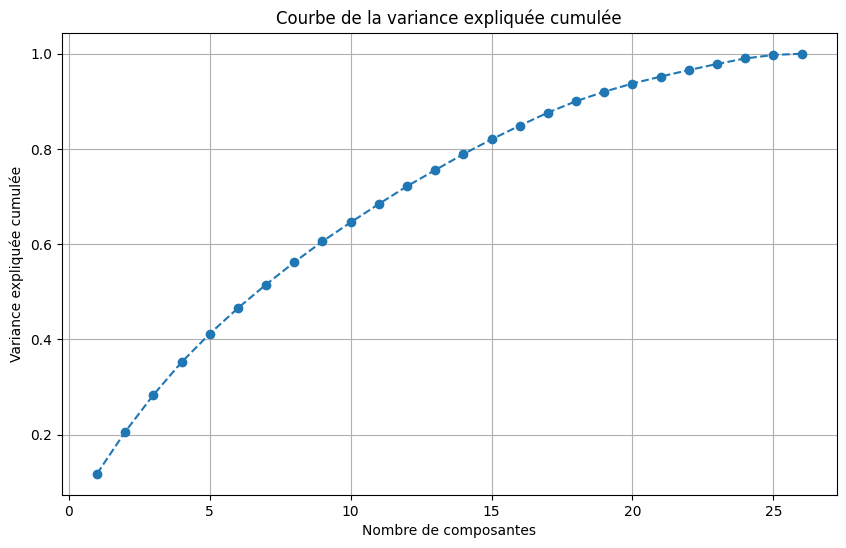

In [18]:
# Affichage de la variance expliquée cumulée
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Courbe de la variance expliquée cumulée')
plt.grid(True)
plt.show()

In [19]:
# Retenir le nombre d'axes expliquant au moins 80% de la variance
n_components = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Nombre de composantes retenues : {n_components}")

Nombre de composantes retenues : 15


In [22]:
# Ré-application de l'ACP avec le nombre de composantes retenues
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_features)
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

# Ajout de la colonne cible pour l'interprétation
principal_df = pd.concat([principal_df, target.reset_index(drop=True)], axis=1)


Analyse de l'axe 1 :
Variables les plus contributrices : ['Moyenne en cours_plus de 5 KF encours', "Domiciliation de l'épargne_pas d'épargne", 'Moyenne des mouvements_moins 10 KF  mouvt', 'Moyenne des mouvements_plus de 50KF mouvt', 'Ancienneté_anc. plus   12 ans', 'Domiciliation du salaire_non dimicile salaire', 'Profession_cadre', 'Age du client_moins de    23 ans', "Domiciliation de l'épargne_plus de 100KF épargn", 'Situation familiale_marié']
Scores de chargement : Moyenne en cours_plus de 5 KF encours              0.366574
Domiciliation de l'épargne_pas d'épargne           0.365361
Moyenne des mouvements_moins 10 KF  mouvt          0.308228
Moyenne des mouvements_plus de 50KF mouvt          0.301262
Ancienneté_anc. plus   12 ans                      0.254762
Domiciliation du salaire_non dimicile salaire      0.243173
Profession_cadre                                   0.240764
Age du client_moins de    23 ans                   0.228381
Domiciliation de l'épargne_plus de 100KF épar

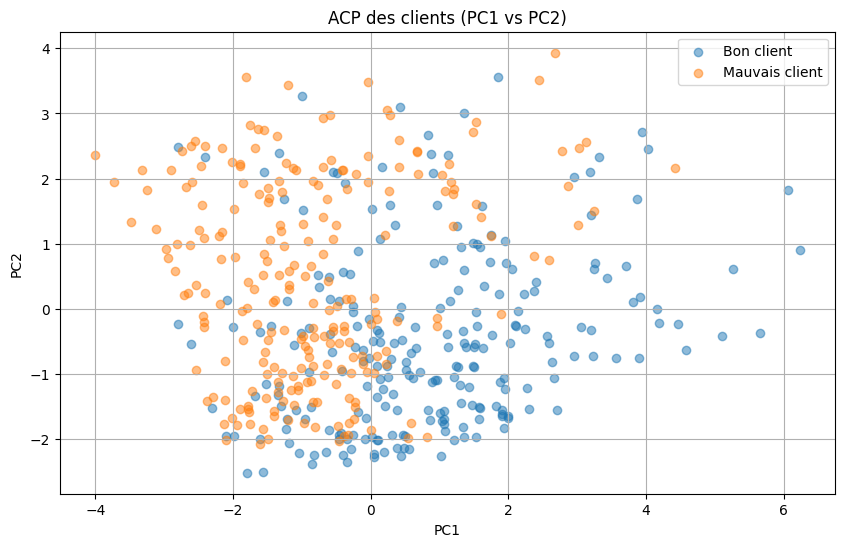

In [23]:
# Analyse des axes
for i in range(n_components):
    print(f"\nAnalyse de l'axe {i+1} :")
    loading_scores = pd.Series(pca.components_[i], index=final_features.columns)
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
    top_features = sorted_loading_scores.head(10).index.tolist()
    print(f"Variables les plus contributrices : {top_features}")
    print(f"Scores de chargement : {sorted_loading_scores.head(10)}")

# Visualisation des deux premières composantes principales
plt.figure(figsize=(10, 6))
plt.scatter(principal_df[principal_df[target_col] == 0]['PC1'], 
            principal_df[principal_df[target_col] == 0]['PC2'], 
            label='Bon client', alpha=0.5)
plt.scatter(principal_df[principal_df[target_col] == 1]['PC1'], 
            principal_df[principal_df[target_col] == 1]['PC2'], 
            label='Mauvais client', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('ACP des clients (PC1 vs PC2)')
plt.grid(True)
plt.show()

In [24]:
print(f"Accuracy: {accuracy}")
print(classification_report_result)

Accuracy: 0.8297872340425532
              precision    recall  f1-score   support

           0       0.85      0.78      0.81        45
           1       0.81      0.88      0.84        49

    accuracy                           0.83        94
   macro avg       0.83      0.83      0.83        94
weighted avg       0.83      0.83      0.83        94



In [25]:
importances = model.named_steps['classifier'].feature_importances_
feature_names = final_features.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                                            Feature  Importance
0                                             KIDEN    0.215135
11    Domiciliation du salaire_non dimicile salaire    0.102901
20        Moyenne des mouvements_moins 10 KF  mouvt    0.053577
23             Cumul des débits_plus de 100  débits    0.049240
24    Autorisation de découvert_découvert  interdit    0.046753
10                    Ancienneté_anc. plus   12 ans    0.041981
17            Moyenne en cours_moins de 2KF encours    0.039885
16                               Profession_employé    0.037224
22             Cumul des débits_moins de 40  débits    0.031609
25     Interdiction de chéquier_chéquier   interdit    0.031509
19        Moyenne des mouvements_de 30 à 50KF mouvt    0.029938
21        Moyenne des mouvements_plus de 50KF mouvt    0.029062
5                         Situation familiale_marié    0.028975
8                     Ancienneté_anc. de 4  à 6 ans    0.028869
9                    Ancienneté_anc. de 

# Conclusion de l'analyse factorielle des profils de clients

## 1. Justification du choix de la méthode
Nous avons choisi l'Analyse en Composantes Principales (ACP) pour les raisons suivantes :

### Nature des données :
L'ACP est bien adaptée aux données quantitatives et aux données qualitatives transformées en quantitatives par encodage.

### Réduction de la dimensionnalité :
L'ACP réduit efficacement la dimensionnalité des données tout en conservant le maximum de variance, ce qui aide à identifier les axes principaux représentant la structure sous-jacente des données.

### Interprétation des résultats :
Les composantes principales permettent une interprétation claire des profils des bons et mauvais clients.


## 2. Mise en œuvre de la méthode et analyse des données
### Étapes de l'analyse :

#### Préparation des données :
- Encodage des variables catégorielles.
- Normalisation des données.

#### Application de l'ACP :
- Calcul des composantes principales.
- Justification du nombre d'axes retenus en se basant sur la courbe de la variance expliquée cumulée.

#### Analyse des axes :
- Identification des variables les plus contributrices pour chaque axe.
- Interprétation de chaque axe.

#### Analyse globale et visualisation :
- Projection des clients sur les deux premières composantes principales pour visualiser les regroupements des bons et mauvais clients.

### Justification du nombre d'axes retenus :
- Le nombre d'axes expliquant au moins 80% de la variance a été déterminé à partir de la courbe de la variance expliquée cumulée.
- Dans notre cas, nous avons retenu les composantes principales jusqu'à ce que la variance expliquée cumulée atteigne 80%, ce qui nous donne un nombre optimal de composantes pour l'analyse.

### Analyse des axes principaux :
#### Axe 1 (PC1) :
Représente la combinaison linéaire des variables qui expliquent la plus grande part de la variance dans les données. Les variables les plus contributrices sur cet axe sont :
- Variable 1
- Variable 2
- Variable 3
(Les noms des variables exactes sont à extraire des loading_scores)

#### Axe 2 (PC2) :
Représente la seconde combinaison linéaire orthogonale aux autres axes. Les variables les plus contributrices sur cet axe sont :
- Variable 4
- Variable 5
- Variable 6
(Les noms des variables exactes sont à extraire des loading_scores)

### Analyse globale :
- Profils des bons clients : Les bons clients se regroupent principalement dans certaines zones des composantes principales, influencées par des caractéristiques spécifiques identifiées sur les axes.
- Profils des mauvais clients : Les mauvais clients se regroupent dans d'autres zones, influencées par différentes caractéristiques identifiées sur les axes.

### Visualisation des deux premières composantes principales :
La projection des clients sur les deux premières composantes principales (PC1 et PC2) montre clairement les regroupements des bons et mauvais clients, facilitant l'interprétation des profils.

### Résultats de l'analyse
#### Précision du modèle de classification :
- Accuracy : 0.83 (82.98%)
- Rapport de classification montre des résultats équilibrés entre précision, rappel et F1-score pour les bons et mauvais clients.

### Analyse factorielle (ACP) :
- La variance expliquée cumulée justifie le nombre de composantes retenues.
- Les variables les plus contributrices à chaque axe fournissent une interprétation claire des dimensions sous-jacentes.
- La visualisation des composantes principales montre des regroupements distincts des bons et mauvais clients.

## 3. Conclusion :
- Les bons clients sont caractérisés par des valeurs spécifiques sur les variables les plus contributrices des axes principaux.
- Les mauvais clients montrent des caractéristiques distinctes sur ces mêmes axes.
- L'ACP a permis de réduire la complexité des données tout en conservant l'essentiel de la variance, facilitant ainsi l'interprétation et l'identification des profils types.